# Changes in mean vs extremes
This notebook is for plotting:

- **Figure 4**: Difference in impact of climate change on mean vs extremes normalized over the mean present-day residual load 
- **Supplementary Figure 4**: Difference in impact of climate change on mean vs extremes normalized over the mean 

Requires running select_EDWs.py first

In [1]:
import glob
import os
import geopandas as gpd
import mappings
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
from PIL import Image

df_countries = mappings.df_countries

# Define regions and corresponding countries
cs = ['Norway', 'France', 'Sweden', 'Poland', 'Austria', 'Hungary', 'Lithuania', 'Latvia', 'Estonia', 'Germany', 
      'Croatia', 'Switzerland', 'Belgium', 'Netherlands', 'Portugal', 'Spain', 'Ireland', 'Italy', 'Denmark', 
      'United Kingdom', 'Slovenia', 'Finland', 'Slovakia', 'Czechia']
cs_iso = [df_countries.loc[df_countries.name == c].index[0] for c in cs]

# Region keys and their country abbreviations
keys = ['Nordic', 'British Isles', 'North Western', 'Central', 'Iberia', 'Baltic', 'Eastern']
abr = ['NRD', 'BRI', 'NWE', 'CEN', 'IBA', 'BAL', 'EAS']
values = [['NOR', 'SWE', 'FIN'], ['GBR', 'IRL'], ['DNK', 'DEU', 'NLD', 'BEL'], ['FRA', 'ITA', 'CHE', 'AUT'],
          ['ESP', 'PRT'], ['EST', 'LVA', 'LTU'], ['POL', 'HRV', 'HUN', 'CZE', 'SVN', 'SVK']]


def sum_per_region(regions, region_files, savenc=False, abbreviations=None, ofolder=None, runname=None):
    """
    Sums datasets by region and optionally saves the resulting dataset to NetCDF.

    Args:
        regions (dict): Dictionary mapping region names to list of countries.
        region_files (dict): Dictionary mapping region names to file paths of NetCDF files.
        savenc (bool): Whether to save the resulting dataset to a NetCDF file.
        abbreviations (list): List of region abbreviations.
        ofolder (str): Output folder path to save NetCDF files.
        runname (str): Name of the run to append to output filenames.
    
    Returns:
        xarray.DataArray: Concatenated dataset with summed regional data.
    """
    ds_list = []

    # Sum data for each region
    for (name, countries), abbreviation in zip(regions.items(), abr):
        ds = xr.open_mfdataset(region_files[name])
        summed_ds = ds.sum(dim='country')

        # Add a new dimension 'region' to the dataset
        new_dim = xr.DataArray([1], dims='region', coords={'region': [name]})
        expanded_ds = summed_ds.expand_dims({'region': new_dim.region}).broadcast_like(new_dim)

        # Save NetCDF if required
        if savenc:
            expanded_ds.to_netcdf(f'{ofolder}/{abbreviation}_{runname}2.nc')

        ds_list.append(expanded_ds)

    # Concatenate datasets along the 'region' dimension
    ds_regions = xr.concat(ds_list, dim='region')
    return ds_regions.compute()


def get_events(ds, df):
    """
    Extracts data slices for events defined in the event DataFrame.

    Args:
        ds (xarray.Dataset): Dataset containing the data to slice.
        df (pandas.DataFrame): DataFrame with event details (regions, runs, time range).
    
    Returns:
        xarray.Dataset: Concatenated dataset with event-based data slices.
    """
    selected_data = []

    # Iterate through events and slice dataset
    for c in df.region.unique():
        country_events = []
        dfc = df.loc[df.region == c]
        
        for _, event in dfc.iterrows():
            data_slice = ds.sel(runs=event['runs'], region=event['region'], time=slice(event['ts0'], event['tsn']))
            country_events.append(data_slice)

        selected_data.append(xr.concat(country_events, dim='event'))

    # Concatenate data across regions and add event numbers
    ds = xr.concat(selected_data, dim='region')
    ds['event'] = np.arange(1, len(ds.event) + 1)
    return ds


def take_seasonal_mean_of_df(df):
    """
    Computes seasonal means for a DataFrame based on day of the year.

    Args:
        df (pandas.DataFrame): DataFrame with 'dayofyear' as index.
    
    Returns:
        pandas.DataFrame: DataFrame with seasonal means.
    """
    season_dict = {
        'DJF': list(range(1, 60)) + list(range(335, 366)),
        'MAM': list(range(60, 152)),
        'JJA': list(range(152, 244)),
        'SON': list(range(244, 335))
    }

    # Map days to seasons
    day_to_season = {day: season for season, days in season_dict.items() for day in days}

    # Add season column and group by season
    df['season'] = df.index.map(day_to_season)
    return df.groupby('season').mean()


def take_climatology(ds):
    """
    Computes climatology by averaging over all runs and times for each day of the year.

    Args:
        ds (xarray.Dataset): Dataset containing time and run dimensions.
    
    Returns:
        xarray.DataArray: Climatological data.
    """
    return ds.stack(z=['runs', 'time']).groupby('time.dayofyear').mean()


def take_event_means(ds, return_period):
    """
    Computes mean values for a specified return period.

    Args:
        ds (xarray.Dataset): Dataset containing event data.
        return_period (int): The return period to filter events.
    
    Returns:
        xarray.DataArray: Mean values for the specified return period.
    """
    dssub = ds.sel(event=np.arange(1, (1600 / return_period) + 1))
    return dssub.mean(dim=['time', 'event'])


def select_energy_vars(ds):
    """
    Selects specific energy-related variables from the dataset.

    Args:
        ds (xarray.Dataset): Dataset containing energy variables.
    
    Returns:
        xarray.Dataset: Dataset containing selected energy variables.
    """
    varsel = ['residual', 'pv_util', 'wind_onshore', 'wind_offshore', 'ror', 'Eout', 'demand']
    return ds[varsel]


def open_event_df(file, return_period):
    """
    Reads and processes an event DataFrame, filtering by return period.

    Args:
        file (str): Path to the event DataFrame CSV file.
        return_period (int): The return period to filter events.
    
    Returns:
        pandas.DataFrame: Processed event DataFrame.
    """
    df = pd.read_csv(file, index_col=0)
    df = df.rename({'country': 'region'}, axis=1)
    df['region'] = df['region'].map({k: v for k, v in zip(abr, keys)})
    return df.loc[df.event_nr < ((1600 / return_period) + 1)]


def take_seasonal_mean_of_ds(ds):
    """
    Computes seasonal means for an xarray dataset based on 'dayofyear'.

    Args:
        ds (xarray.Dataset): Dataset containing 'dayofyear' dimension.
    
    Returns:
        xarray.Dataset: Dataset with seasonal means.
    """
    season_dict = {
        'DJF': list(range(1, 60)) + list(range(335, 367)),
        'MAM': list(range(60, 152)),
        'JJA': list(range(152, 244)),
        'SON': list(range(244, 335))
    }

    # Map days to seasons
    day_to_season = {day: season for season, days in season_dict.items() for day in days}

    # Add season dimension to dataset
    season = xr.DataArray(np.array([day_to_season[day.item()] for day in ds['dayofyear']]), 
                          dims='dayofyear', coords={'dayofyear': ds['dayofyear']})
    ds = ds.assign_coords(season=season)

    # Compute seasonal means
    return ds.groupby('season').mean(dim='dayofyear')



# import the data  

In [2]:
regions = {k:v for k,v in zip(keys,values)}
regions_flat = [item for sublist in values for item in sublist]

# open files
region_files = glob.glob(f'*_PD.nc')
ds_regions = xr.open_mfdataset(region_files, concat_dim='region')
ds_regions = ds_regions.compute()
region_files = glob.glob(f'*_FU.nc')
ds_regions_future = xr.open_mfdataset(region_files, concat_dim='region')
ds_regions_future = ds_regions_future.compute()
ds_regions_clima =  take_climatology(ds_regions.rolling(time=7).sum())
ds_regions_future_clima = take_climatology(ds_regions_future.rolling(time=7).sum())

difference = ds_regions_future_clima - ds_regions_clima
df = difference.sel(region='Nordic').to_dataframe()
df = df[['residual', 'pv_util', 'wind_onshore', 'wind_offshore', 'ror', 'Eout', 'demand']]

# Define regions and flatten list
regions = {k: v for k, v in zip(keys, values)}
regions_flat = [item for sublist in values for item in sublist]

# Open region files for historical and future data
region_files = glob.glob(f'*_PD.nc')
ds_regions = xr.open_mfdataset(region_files, concat_dim='region')
ds_regions = ds_regions.compute()
ds_regions = ds_regions.fillna(0)
region_files = glob.glob(f'*_FU.nc')
ds_regions_future = xr.open_mfdataset(region_files, concat_dim='region')
ds_regions_future = ds_regions_future.compute()
ds_regions_future = ds_regions_future.fillna(0)

## compute changes 

In [3]:
# set event_length for plot
event_length = 30

# Compute mean differences for climatology
ds_regions_clima = take_climatology(ds_regions.rolling(time=event_length).mean())
ds_regions_future_clima = take_climatology(ds_regions_future.rolling(time=event_length).mean())

# Compute the change in mean
change_in_mean = ds_regions_future_clima - ds_regions_clima
change_in_mean = take_seasonal_mean_of_ds(change_in_mean)

ds_regions_clima = take_seasonal_mean_of_ds(ds_regions_clima)

# Check for events
return_period = 10
season_list_fu = []
season_list_pd = []

for season in ['DJF', 'MAM', 'JJA', 'SON']:
    file = f'residual_el{event_length}_{season}_PD_project3.csv'
    df_pd = open_event_df(file, return_period)
    # Selecting events
    dsevents_pd = get_events(ds_regions, df_pd)
    dsevents_pd_sub = select_energy_vars(dsevents_pd)
    dsevents_mean_pd = take_event_means(dsevents_pd_sub, return_period)
    season_list_pd.append(dsevents_mean_pd)
    
    # Open future events
    file_fu = f'residual_el{event_length}_{season}_FU_project3.csv'
    df_fu = open_event_df(file_fu, return_period)
    # Selecting events
    dsevents_fu = get_events(ds_regions_future, df_fu)
    dsevents_fu_sub = select_energy_vars(dsevents_fu)
    dsevents_mean_fu = take_event_means(dsevents_fu_sub, return_period)
    season_list_fu.append(dsevents_mean_fu)

# Combine season data for future and historical
dsseason_fu = xr.concat(season_list_fu, dim='season')
dsseason_fu['season'] = ['DJF', 'MAM', 'JJA', 'SON']
dsseason_pd = xr.concat(season_list_pd, dim='season')
dsseason_pd['season'] = ['DJF', 'MAM', 'JJA', 'SON']

# Compute the change in extremes
change_in_extremes = dsseason_fu - dsseason_pd

# Compute the difference between mean and events
difference_in_changes = change_in_extremes - change_in_mean


## make plot

In [ ]:
change_in_mean

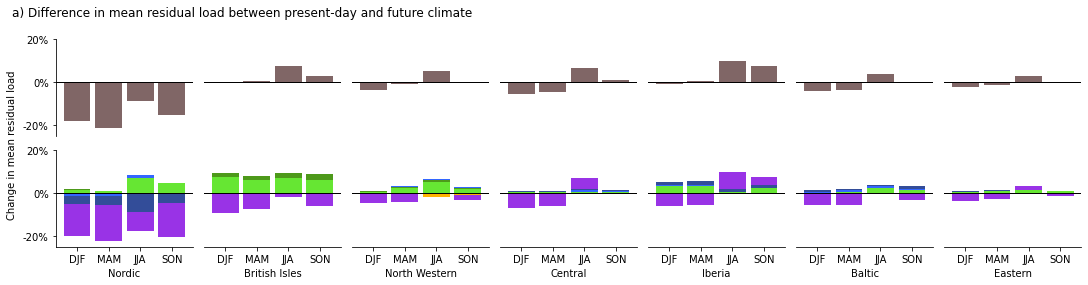

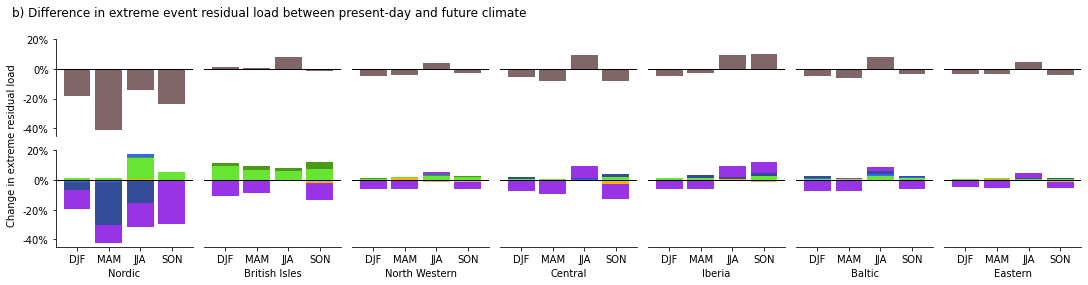

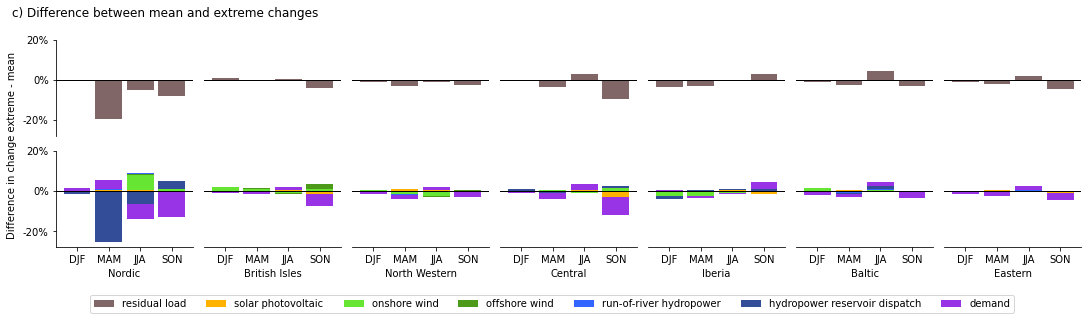

Plot0, Region: Nordic, Max Value: -0.08927939174098502, Min Value: -0.21260243581387162
Plot0, Region: British Isles, Max Value: 0.07590101497607656, Min Value: 0.0025123243490587544
Plot0, Region: North Western, Max Value: 0.050357937245598464, Min Value: -0.03594191111344216
Plot0, Region: Central, Max Value: 0.06649010892636428, Min Value: -0.05504796244572353
Plot0, Region: Iberia, Max Value: 0.09917092350130984, Min Value: -0.011322300144000812
Plot0, Region: Baltic, Max Value: 0.039223050272366396, Min Value: -0.04011260258726785
Plot0, Region: Eastern, Max Value: 0.029782190062503842, Min Value: -0.02534078518815638
Plot1, Region: Nordic, Max Value: -0.1422524848723938, Min Value: -0.4093056591556395
Plot1, Region: British Isles, Max Value: 0.0821246551265068, Min Value: -0.014763728531464135
Plot1, Region: North Western, Max Value: 0.040117266679498734, Min Value: -0.046334482108829796
Plot1, Region: Central, Max Value: 0.09301109366916856, Min Value: -0.08412588755769106
Plot1

In [16]:
# Color settings for plots
colors = [[(1.0, 0.7, 0.0), (0.9, 0.4, 0.1)], 
          [(0.4, 0.9, 0.2), (0.3, 0.6, 0.1)], 
          [(0.2, 0.4, 1), (0.2, 0.3, 0.6)],
          [(0.6, 0.2, 0.9), (0.5, 0.1, 0.7)],
          [(0.5, 0.4, 0.4), (0.3, 0.2, 0.2)]]

metrics = ['pv', 'wind', 'hydro', 'demand', 'residual']
colors_dict = dict(zip(metrics, colors))
colors_extended = [(1.0, 0.7, 0.0), (0.4, 0.9, 0.2), (0.3, 0.6, 0.1), (0.2, 0.4, 1), (0.2, 0.3, 0.6), 
                   (0.6, 0.2, 0.9), (0.5, 0.4, 0.4)]

# Define the datasets and corresponding configurations
datasets = [
    {'data': change_in_mean,
     'normalizer': ds_regions_clima,
     'title': 'a) Difference in mean residual load between present-day and future climate', 
     'ylabel': 'Change in mean residual load', 'panel': 'a'},
    {'data': change_in_extremes,
     'normalizer': ds_regions_clima,  # dsseason_pd,
     'title': 'b) Difference in extreme event residual load between present-day and future climate', 
     'ylabel': 'Change in extreme residual load', 'panel': 'b'},
    {'data': difference_in_changes,
     'normalizer': ds_regions_clima,  # change_in_mean,
     'title': 'c) Difference between mean and extreme changes', 
     'ylabel': 'Difference in change extreme - mean', 'panel': 'c'}
]

# List to store the collected data
collected_data = []

for count, dataset in enumerate(datasets):
    difference = dataset['data']
    title = dataset['title']
    ylabel = dataset['ylabel']
    ds0 = dataset['normalizer']
    
    yrange = [[-0.25, 0.2], [-0.45, 0.2], [-0.28, 0.2]]

    # Create subplots
    fig, axes = plt.subplots(nrows=2, ncols=7, figsize=(15, 4), gridspec_kw={'height_ratios': [1, 1]})
    fig.suptitle(title, horizontalalignment='left', x=0)

    for i, region in enumerate(regions):
        ax1, ax2 = axes[:, i]
        df = difference.sel(region=region).to_dataframe()
        df = df[['residual', 'pv_util', 'wind_onshore', 'wind_offshore', 'ror', 'Eout', 'demand']]
        df_season = df

        # Open the normalizer data
        df0 = ds0.sel(region=region).to_dataframe()
        df0_season = df0[['residual', 'pv_util', 'wind_onshore', 'wind_offshore', 'ror', 'Eout', 'demand']]

        dfplot = (df_season['residual'] / df0_season['residual'])
        dfplot[['DJF', 'MAM', 'JJA', 'SON']].plot(kind='bar', stacked=False, ax=ax1, width=0.85, color=colors_extended[-1])
         # Collect the max and min values and store in the list
        collected_data.append({
            'plot': count,
            'region': region,
            'max_value': dfplot.max(),
            'min_value': dfplot.min()
        })
        
        # Add a horizontal line at y=0 on the bottom panel
        ax1.axhline(y=0, color='black', linestyle='-', linewidth=1)
        ax1.set_ylim(yrange[count][0], yrange[count][1])
        
        # Add percentage sign to the y-axis values of the bottom panel
        ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
        
        if ax1 == axes[0, 0]:
#             ax1.set_ylabel(ylabel)
            ax1.set_xlabel('')
            ax1.set_xticks([])
            ax2.set_xlabel('')
            ax2.set_xticks([])
            ax1.spines['bottom'].set_visible(False)

            for spine in ['top', 'right']:
                ax1.spines[spine].set_visible(False)
                ax2.spines[spine].set_visible(False)
        else:
            for spine in ['top', 'left', 'right']:
                ax1.spines[spine].set_visible(False)
                ax2.spines[spine].set_visible(False)
            ax1.spines['bottom'].set_visible(False)
            ax1.set_xlabel('')
            ax1.set_ylabel('')
            ax1.set_title('')
            ax1.set_xticks([])
            ax1.set_yticks([])

            ax2.set_xlabel('')
            ax2.set_ylabel('')
            ax2.set_title('')
            ax2.set_xticks([])
            ax2.set_yticks([])

        # Normalize each column by the 'residual' column
        normalized_df = df_season.div(df0_season['residual'], axis=0)
        normalized_df['demand'] = normalized_df['demand'] * -1

        # Plot the normalized dataframe as a stacked bar plot on the bottom panel
        dfplot = (normalized_df * -1).drop('residual', axis=1)
        dfplot.loc[['DJF', 'MAM', 'JJA', 'SON'], :].plot(kind='bar', stacked=True, ax=ax2, width=0.85, 
                                                           legend=False, color=colors_extended)

        # Add a horizontal line at y=1 on the bottom panel
        ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)

        # Add labels and title for the bottom panel
        ax2.set_xlabel(region)

        # Add percentage sign to the y-axis values of the bottom panel
        ax2.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
        ax2.set_ylim(yrange[count][0], yrange[count][1])

    # Adjust the spacing between subplots
    plt.subplots_adjust(hspace=0.1, wspace=0.1)
    
    if dataset['panel'] == 'c':
        # Collect legend handles and labels from the bottom left subplot
        handles1, labels1 = axes[0, 0].get_legend_handles_labels()
        handles2, labels2 = axes[1, 0].get_legend_handles_labels()
        handles1.extend(handles2)
        labels1.extend(labels2)

        labels_dict = {'residual': 'residual load',
                       'pv_util': 'solar photovoltaic',
                       'wind_onshore': 'onshore wind',
                       'wind_offshore': 'offshore wind',
                       'ror': 'run-of-river hydropower',
                       'Eout': 'hydropower reservoir dispatch',
                       'demand': 'demand'}

        labels1 = [labels_dict[l] for l in labels1]
        
        # Add a common legend at the bottom of the figure
        fig.legend(handles1, labels1, loc='lower center', ncol=7, bbox_to_anchor=(0.5, -0.1))
    # Dynamically calculate the position for the y-axis label
    ylabel_x_position = 0.0  # Adjust as needed for placement
    ylabel_y_position = 0.5   # Centered vertically
    fig.text(
        ylabel_x_position,  # x position based on column
        ylabel_y_position,                          # y position
        ylabel,                                     # Text to display
        va='center', ha='center', rotation='vertical', fontsize=10
    )
    # Adjust layout and save the plot
    plt.tight_layout()
    panel = dataset['panel']
    plt.savefig(f'frequency{panel}_el{event_length}_rollingDispatch.png', dpi=300, bbox_inches='tight')
    plt.show()

# Print collected data at the end
for data in collected_data:
    print(f"Plot{data['plot']}, Region: {data['region']}, Max Value: {data['max_value']}, Min Value: {data['min_value']}")

### combine into one figure

In [17]:
from PIL import Image

# List of image paths to combine
images_to_combine = [f'frequency{panel}_el{event_length}_rollingDispatch.png' for panel in ['a', 'b', 'c']]

try:
    # Open the images
    images = [Image.open(file) for file in images_to_combine]

    # Get the width and height of each image
    widths, heights = zip(*[img.size for img in images])

    # Determine the total height and max width for the combined image
    total_height = sum(heights)
    max_width = max(widths)

    # Create a new blank image with the total height and max width
    new_image = Image.new('RGB', (max_width, total_height))

    # Paste the images one below the other
    y_offset = 0
    for img in images:
        new_image.paste(img, (0, y_offset))
        y_offset += img.height

    # Save the new combined image
    output_path = f'/usr/people/most/03_project3/img/frequency_el{event_length}_rollingDispatch.png'
    new_image.save(output_path)
    print(output_path)

except Exception as e:
    print(f"An error occurred: {e}")


/usr/people/most/03_project3/img/frequency_el30_rollingDispatch.png


# relative to itself instead of to residual

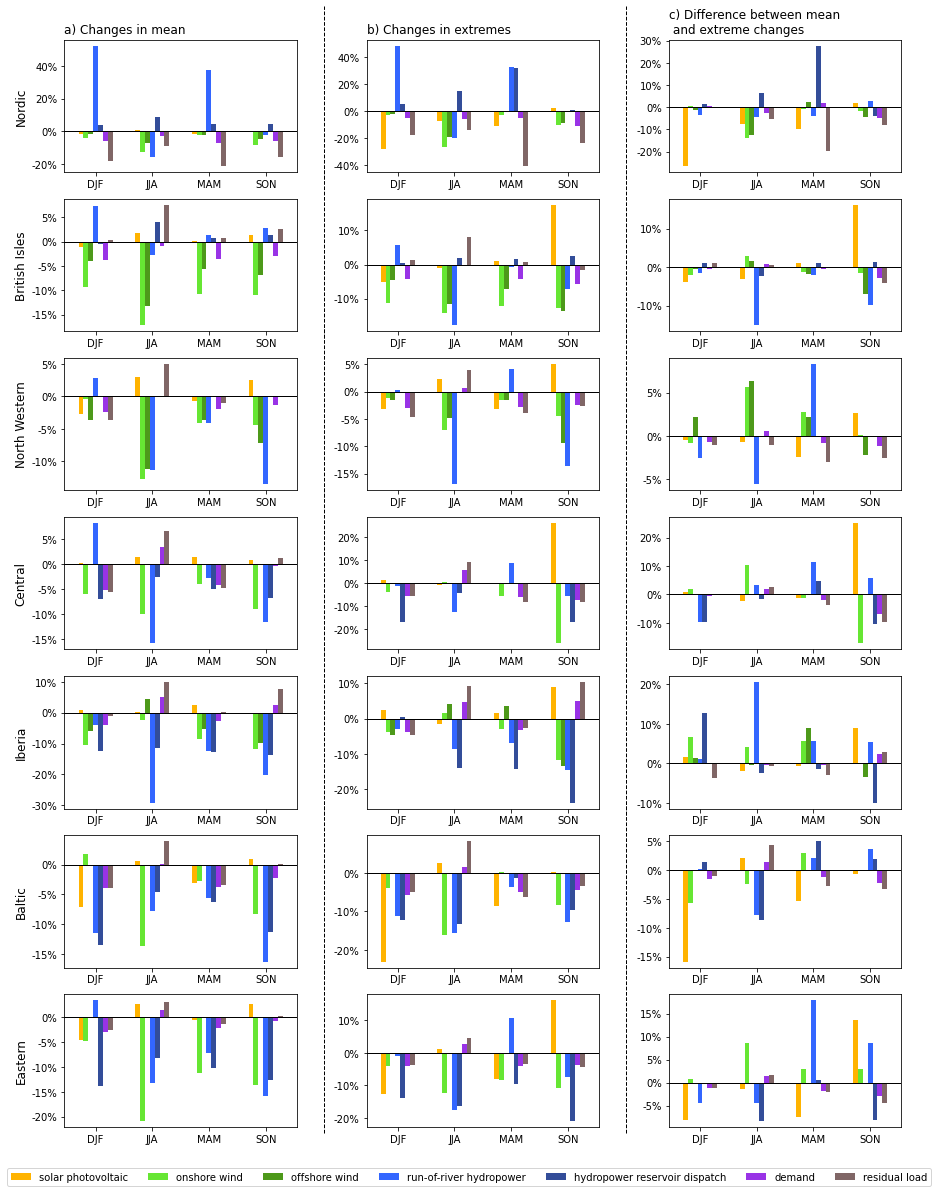

In [40]:
# Color settings for plots
colors = [[(1.0, 0.7, 0.0), (0.9, 0.4, 0.1)], 
          [(0.4, 0.9, 0.2), (0.3, 0.6, 0.1)], 
          [(0.2, 0.4, 1), (0.2, 0.3, 0.6)],
          [(0.6, 0.2, 0.9), (0.5, 0.1, 0.7)],
          [(0.5, 0.4, 0.4), (0.3, 0.2, 0.2)]]

metrics = ['pv', 'wind', 'hydro', 'demand', 'residual']
colors_dict = dict(zip(metrics, colors))
colors_extended = [(1.0, 0.7, 0.0), (0.4, 0.9, 0.2), (0.3, 0.6, 0.1), (0.2, 0.4, 1), (0.2, 0.3, 0.6), 
                   (0.6, 0.2, 0.9), (0.5, 0.4, 0.4)]

# Define the datasets and corresponding configurations
datasets = [
    {'data': change_in_mean,
     'normalizer': ds_regions_clima,
     'title': 'a) Difference in mean residual load between present-day and future climate', 
     'ylabel': 'Change in \n mean residual load', 'panel': 'a'},
    {'data': change_in_extremes,
     'normalizer': ds_regions_clima,  # dsseason_pd,
     'title': 'b) Difference in extreme event residual load between present-day and future climate', 
     'ylabel': 'Change in \n extreme residual load', 'panel': 'b'},
    {'data': difference_in_changes,
     'normalizer': ds_regions_clima,  # change_in_mean,
     'title': 'c) Difference between mean and extreme changes', 
     'ylabel': 'Difference in change \n extreme - mean', 'panel': 'c'}
]

# Create subplots with one row (second row)
fig, allaxes = plt.subplots(nrows=7, ncols=3, figsize=(15, 20))

# Titles for each plot column
titles = ['a) Changes in mean', 'b) Changes in extremes', 'c) Difference between mean \n and extreme changes']

# Prepare an empty list for collecting the analysis results
analyse_min_max = []

# Loop through datasets and regions
for count, dataset in enumerate(datasets):
    difference = dataset['data']
    title = dataset['title']
    ylabel = dataset['ylabel']
    ds0 = dataset['normalizer']
    
    axes = allaxes[:, count]
    axes[0].set_title(titles[count], horizontalalignment='center', x=0.5)

    # Loop over each region
    for i, region in enumerate(regions):
        ax2 = axes[i]  # Use ax2 directly for each region plot
        df = difference.sel(region=region).to_dataframe()
        df = df[['pv_util', 'wind_onshore', 'wind_offshore', 'ror', 'Eout', 'demand', 'residual']]
        df_season = df

        # Normalize the dataframe using the normalizer
        df0 = ds0.sel(region=region).to_dataframe()
        df0_season = df0[['pv_util', 'wind_onshore', 'wind_offshore', 'ror', 'Eout', 'demand', 'residual']]

        # Normalize each column by 'residual' column
        normalized_df = df_season.div(df0_season, axis=0)
        normalized_df['demand'] = normalized_df['demand']  # Ensure demand remains unchanged
        normalized_df = normalized_df.fillna(0)

        # Plot the normalized dataframe as a stacked bar plot
        normalized_df.plot(kind='bar', stacked=False, ax=ax2, width=0.6, legend=False, color=colors_extended)

        # Add a horizontal line at y=0
        ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)

        # Add labels and title for each subplot
        ax2.set_xlabel('')
        if count == 0:
            ax2.set_ylabel(region, rotation=90, size='large')

        # Store the mean changes for further analysis
        analyse_min_max.append(normalized_df)

        # Add percentage sign to the y-axis values
        ax2.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

        # Set xticks to be horizontal
        ax2.tick_params(axis='x', rotation=0)

# Remove individual titles from the other axes
for ax in allaxes.ravel():
    ax.set_title('')

# Set titles for the first row of subplots
for i in range(3):
    allaxes[0, i].set_title(titles[i], ha='left', x=0)
    
# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.2, wspace=0.3)

# Collect legend handles and labels from the last subplot in the first column
handles, labels = axes[0].get_legend_handles_labels()

# Map original labels to more descriptive ones
labels_dict = {
    'residual': 'residual load',
    'pv_util': 'solar photovoltaic',
    'wind_onshore': 'onshore wind',
    'wind_offshore': 'offshore wind',
    'ror': 'run-of-river hydropower',
    'Eout': 'hydropower reservoir dispatch',
    'demand': 'demand'
}
labels = [labels_dict[l] for l in labels]

# Add a common legend at the bottom of the figure
fig.legend(handles, labels, loc='upper center', ncol=7, bbox_to_anchor=(0.5, 0.1))

# Add vertical lines between columns after plotting (for each column separation)
for col in range(1, 3):  # Between the first & second, and second & third columns
    x_position = col-1.2  # This is the index of the column where the line will be added
    for ax in allaxes[:, col]:  # Loop through all rows in the specific column
        ax.axvline(x=-1.3, ymin=-0.05, ymax=1.25, color='black', linestyle='--', linewidth=1, clip_on=False)
    
# Save the figure as a high-quality PNG file
plt.savefig(f'frequency_el{event_length}_relative_to_itself.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()